In [1]:
import torch
from torch import nn 
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from pyDOE import lhs
import time
import math
import seaborn as sns
import numpy as np

In [2]:
torch.manual_seed(42)#Set a seed for reproducibility
np.random.seed(42) #Seed for lhs

In [3]:
class NN(nn.Module):
    def __init__(self,):
        super(NN, self).__init__()
        #Linear layers
        self.mod = nn.Sequential(
            nn.Linear(2, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            #nn.Linear(20, 20),
            #torch.nn.Tanh(),
            #nn.Linear(20, 20),
            #torch.nn.Tanh(),
            #nn.Linear(20, 20),
            #torch.nn.Tanh(),
            #nn.Linear(20, 20),
            #torch.nn.Tanh(),
            nn.Linear(20, 1)
        )
        
    def forward(self, inpu):
        out = self.mod(inpu)
        return out

In [4]:
class Model:
    def __init__(self):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(self.device)
        self.model = NN().to(self.device)
        
        #Max iteration
        self.max_iter = 1000
        
        #Criterion for loss 
        self.criterion = nn.MSELoss()
        
        #Optimizer
        self.optimizer = optim.Adam(self.model.parameters())
        
        self.lbfgs = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=20,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps
        )
        N_u = 100
        N_f = 10000
        
        #Initialization for training
        self.x_step = 2/255 
        self.t_step = 1/99
        x = torch.arange(-1, 1+self.x_step, self.x_step) #create grid for x-axis (256)
        t = torch.arange(0, 1 + self.t_step, self.t_step) #create grid for t-axis (100)
        """
        #Create grid for solution
        self.grid = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T.to(self.device) # Create grid of 2D points
        self.grid.requires_grad = True
        """
        #Create collocation points
        colloc= np.array([-1,0]) + (np.array([1,1])-np.array([-1,0]))*lhs(2, N_f)
        self.grid = torch.from_numpy(colloc).to(torch.float32).to(self.device) #Convert to float32 to avoid computational problems
        self.grid.requires_grad = True
        print(self.grid.size())
        
        #Training data for boundary conditions and initial condition
        bound_1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T # Points for first boundary condition (100,2)
        bound_2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T #Points for second boundary condition (100,2)
        initial = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T # Points for initial condition for x at t=0 (256,2)
        
        self.train_points = torch.cat([bound_1, bound_2, initial]).to(self.device) # Training points as a grid (initial and boundary cond)
        perm= torch.randperm(self.train_points.size(0))
        idx=perm[:N_u]
        self.train_points= self.train_points[idx]
        print(self.train_points.size())
        u_b1 = torch.zeros(len(bound_1))
        u_b2 = torch.zeros(len(bound_2))
        u_initial = -torch.sin(math.pi * initial[:, 0])# use initial condition from paper (Dirichlet boundary conditions)
        self.y_train = torch.cat([u_b1, u_b2, u_initial])
        self.y_train = self.y_train[idx]
        self.y_train = self.y_train.unsqueeze(1).to(self.device)
        """
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True
        """
        self.iter = 1


    
    def loss(self):
        #self.optimizer.zero_grad()
        self.lbfgs.zero_grad()
        
        y = self.model(self.train_points)
        loss_u = self.criterion(y, self.y_train) #Compute first part of loss
        u = self.model(self.grid)
        
        #Compute gradients of grid with respect to u and t
        du_dX = torch.autograd.grad(inputs=self.grid, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dx2 = torch.autograd.grad(inputs=self.grid, outputs=du_dX, grad_outputs=torch.ones_like(du_dX), retain_graph=True, create_graph=True)[0][:, 0]
        
        loss_f =self.criterion(du_dt + u.squeeze() * du_dx, 0.01/math.pi *du_dx2) #Second part of loss, using f(t,x) as in paper
        
        loss = loss_u+loss_f
        loss.backward()
        #Print loss every 100 iteration
        if self.iter % 100 == 0: 
            print(self.iter, loss_u.item(), loss_f.item(), loss.item())
        self.iter = self.iter + 1
        return loss

    def train(self):
        for i in range(self.max_iter):
            self.optimizer.step(self.loss)
        self.lbfgs.step(self.loss)
        
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(self.device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(self.device)

        self.model.eval()
        u = self.model(torch.cat([x, t], dim=1))
        u = u.detach().cpu().numpy()
        return u


In [5]:
model = Model()
model.train()

cuda:0
torch.Size([10000, 2])


P:\Programmes\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([100, 2])
100 0.14825347065925598 0.007265940774232149 0.15551941096782684
200 0.06521761417388916 0.027951139956712723 0.09316875040531158
300 0.0529213510453701 0.02420303039252758 0.07712437957525253
400 0.04393007233738899 0.01951720006763935 0.06344727426767349
500 0.039963219314813614 0.018400369212031364 0.05836358666419983
600 0.03811373561620712 0.015723861753940582 0.053837597370147705
700 0.03631432354450226 0.013735623098909855 0.05004994571208954
800 0.035667724907398224 0.012386837974190712 0.04805456101894379
900 0.03389944136142731 0.011686758138239384 0.045586198568344116
1000 0.03230459615588188 0.011002789251506329 0.043307386338710785
1100 0.016661884263157845 0.009507537819445133 0.026169423013925552
1200 0.003584857564419508 0.005787396803498268 0.009372254833579063
1300 0.0016996976919472218 0.0022325676400214434 0.003932265564799309
1400 0.0012931686360388994 0.001383916474878788 0.0026770851109176874
1500 0.0009023604216054082 0.0011082054115831852 0

In [6]:
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# exact solution
grid = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
grid = grid.to(model.grid.device)

In [7]:
mod = model.model
mod.eval()
with torch.no_grad():
    y_pred = mod(grid).reshape(len(x), len(t)).cpu().numpy()

<AxesSubplot:>

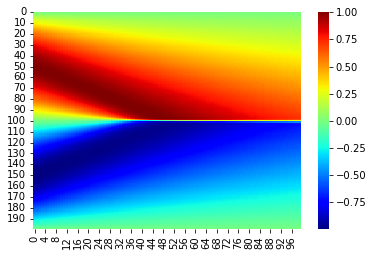

In [8]:
sns.heatmap(y_pred, cmap='jet')

In [9]:
import scipy.io

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None] #(100, 1)
x = data['x'].flatten()[:,None] #(256, 1)
Exact = np.real(data['usol']).T #(100, 256)

X, T = np.meshgrid(x,t) #(100, 256) for each

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) #(25600, 2)
u_star = Exact.flatten()[:,None] #(25600, 1)



u_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u)) #use this metric to compare model performance    
print("L2-norm: %f" %(np.sum(error_u**2)**1/2))

Error u: 2.428767e-02
L2-norm: 0.000295
